<a href="https://colab.research.google.com/github/jwoonge/ML-projects/blob/master/11/assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network for the classification task on MNIST
20141261 송제웅
<hr>
  
## 0. Import library
<hr>

In [81]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import math

## 1. Download and Normalize dataset (MNIST)
---


In [82]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),
])

data_path = './MNIST'
data_train = datasets.MNIST(root = data_path, train = False, download = True, transform = transform)
data_test = datasets.MNIST(root = data_path, train = True, download = True, transform = transform)

## 2. Design Model
---

In [88]:
class CNN_module(nn.Module):
    def __init__(self, num_class=10, size_kernel=5):
        super(CNN_module, self).__init__()
        self.num_class = num_class
        self.size_kernel = size_kernel

        #### Feature Layer ####
        self.conv1 = nn.Conv2d(1, 20, kernel_size=self.size_kernel, stride=1, padding=int((size_kernel-1)/2), bias=True)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=self.size_kernel, stride=1, padding=int((size_kernel-1)/2), bias=True)

        self.conv_layer1 = nn.Sequential(self.conv1, nn.MaxPool2d(kernel_size=2), nn.ReLU(True))
        self.conv_layer2 = nn.Sequential(self.conv2, nn.MaxPool2d(kernel_size=2), nn.ReLU(True))

        self.feature = nn.Sequential(self.conv_layer1, self.conv_layer2)
    
        #### Classifier Layer ####
        self.fc1        = nn.Linear(50*7*7, 128, bias=True)
        self.fc2        = nn.Linear(128, num_class, bias=True)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.Sigmoid())

        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2)
        self._initialize_weight() 

    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
                if m.bias is not None:
                    m.bias.data.zero_()
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(-1, 50*7*7)
        x = self.classifier(x)
        return x


## 3. Define functions for Learning
---

In [84]:
def train(model, data_train, data_train_batch, optimizer, criterion, device='cuda'):
    model.train()
    n_batch = 0
    avg_loss = 0
    avg_acc = 0
    for batch_idx, (x, y) in enumerate(data_train_batch):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model.forward(x)
        loss = criterion(pred, y)
        avg_loss += loss.item()
        avg_acc += accuracy(pred, y)
        n_batch += 1

        loss.backward()
        optimizer.step()
    avg_loss /= n_batch
    avg_acc /= n_batch
    return avg_loss, avg_acc

def test(model, x, y, criterion):
    model.eval()
    with torch.no_grad():
        pred = model.forward(x)
        loss = criterion(pred, y).item()
        acc = accuracy(pred, y)
    return loss, acc

def accuracy(pred, y):
    return 100*(torch.sum(torch.argmax(pred, dim=1)==y)).item()/len(y)

In [85]:
def learn(model, data_train, data_test, criterion, optimizer, batch_size, epoch, device='cuda'):
    data_train_batch = torch.utils.data.DataLoader(data_train, batch_size, shuffle=True)
    data_train = data_train.train_data.unsqueeze(1)
    test_x = data_test.test_data.unsqueeze(1)
    test_y = data_test.test_labels
    test_x, test_y = torch.tensor(test_x, dtype=torch.float, device=device), test_y.to(device)
    i = 0
    while i<epoch:
        losstest, acctest = test(model, test_x, test_y, criterion)
        losstrain, acctrain = train(model, data_train, data_train_batch, optimizer, criterion, device)
        
        loss_train.append(losstrain); loss_test.append(losstest)
        acc_train.append(acctrain); acc_test.append(acctest)
        i += 1
        print(len(loss_train),'\t', losstrain,'\t', acctrain,'\t', losstest,'\t', acctest)

In [86]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

## 4. Learn
---

In [ ]:
global loss_train, loss_test, acc_train, acc_test
loss_train = []; loss_test = []; acc_train = []; acc_test = []
model = CNN_module().to(device)
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss2d()
while True:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0015)
    learn(model, data_train, data_test, criterion, optimizer, 64, 1, device)
    if acc_test[-1] > 95:
        break

In [ ]:
while True:
    if len(acc_test)==900:
        break
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0015)
    learn(model, data_train, data_test, criterion, optimizer, 64, 1, device)

In [95]:
print(acc_test[-1])

97.18666666666667


---
# RESULTS
---
## 1. Plot the training and testing losses over epochs
---

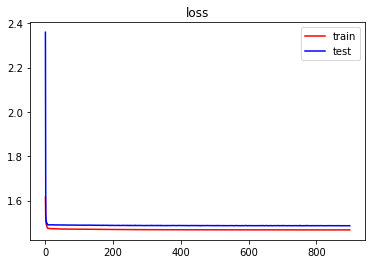

In [97]:
plt.plot(loss_train, color='r')
plt.plot(loss_test, color='b')
plt.title('loss')
plt.legend(['train','test'])
plt.show()

## 2. Plot the training and testing accuracies at convergence
---

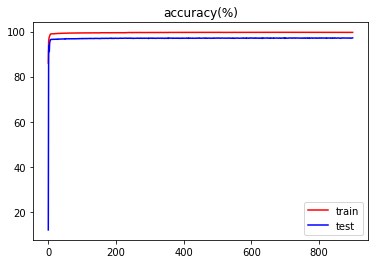

In [98]:
plt.plot(acc_train, color='r')
plt.plot(acc_test, color='b')
plt.title('accuracy(%)')
plt.legend(['train','test'])
plt.show()

## 3. Print the final training and testing losses at convergence
---

In [99]:
print('training loss\t',loss_train[-1])
print('testing loss\t',loss_test[-1])

training loss	 1.4675300371874669
testing loss	 1.4864470958709717


## 4. Print the final training and testing accuracies at convergence

---



In [100]:
print('training accuracy\t',acc_train[-1])
print('testing accuracy\t',acc_test[-1])

training accuracy	 99.6218152866242
testing accuracy	 97.18666666666667


## 5. Print the testing accuracies within the last 10 ephochs
---

In [101]:
for epoch in range(len(acc_test)-10, len(acc_test)):
    print('[epoch =',epoch,']',round(acc_test[epoch],5))

[epoch = 890 ] 97.13333
[epoch = 891 ] 97.11167
[epoch = 892 ] 97.01
[epoch = 893 ] 97.08667
[epoch = 894 ] 97.06167
[epoch = 895 ] 97.055
[epoch = 896 ] 97.04833
[epoch = 897 ] 97.12167
[epoch = 898 ] 97.12
[epoch = 899 ] 97.18667
